In [302]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.integrate import nquad
import pandas as pd

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [306]:
s = Survey(l, b, ds, obsTime, survey_area=survey_area, n_sources=n_sources)
s

Survey(l=1.0, b=-1.03, source_dist=9.0, obs_time=70, survey_area=0)

In [307]:
t_es = np.logspace(-3, 1, 20) #hours

In [5]:
m = 1e-8
s.add_pbh(m)
diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


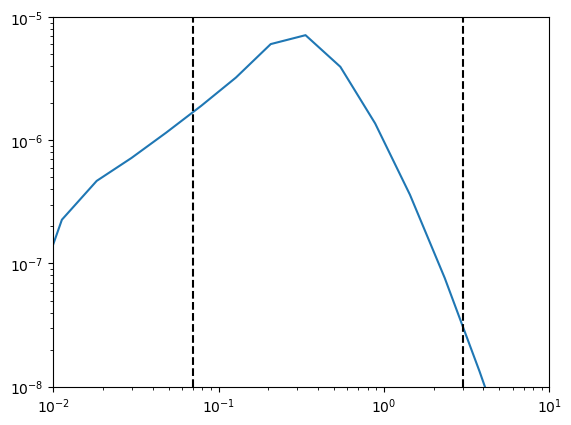

In [6]:
plt.loglog(t_es, diff_rates)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8,1e-5)
plt.show()

In [7]:
diff_rate_interp = interp1d(t_es, diff_rates)

In [8]:
ti = 0.07
tf = 3
dnds = quad(diff_rate_interp, ti, tf)[0]

In [9]:
s.n_sources*efficiency*dnds

216.14108757430105

In [10]:
def get_n_events(m, finite=False):
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=finite)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*efficiency*dnds*obsTime

def get_constraint_fdm(m, finite=False):
    n_events = get_n_events(m, finite=finite)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1
    
def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        # results = list(p.imap(f, m_pbhs))
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [11]:
m_pbhs = np.logspace(-15, -4, 25) #solar masses
fdms = get_constraint_fdm_parallel(m_pbhs, finite=False)

100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


In [12]:
fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)

100%|██████████| 25/25 [00:30<00:00,  1.21s/it]


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, dis

In [13]:
# Define conversion factor
sol_to_gram = 1.989e33
m_grams = [x*sol_to_gram for x in m_pbhs]

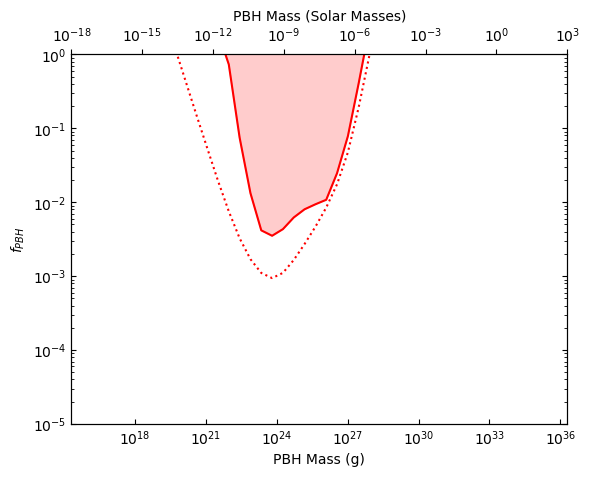

In [14]:
# Define conversion factor
sol_to_gram = 1.989e33

fig, ax2 = plt.subplots()

# Plot on first x-axis
ax2.plot(m_grams, fdms, 'r', ls=':')
ax2.plot(m_grams, fdm_finite, 'r', ls='-')
ax2.fill_betweenx(fdm_finite, m_grams, color='r', alpha=0.2)  # shade the area above the curve
# ax2.fill_betweenx(fdms, [x*sol_to_gram for x in m_pbhs], color='r', alpha=0.2)  # shade the area above the curve

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('PBH Mass (g)')
ax2.set_ylabel(r'$f_{PBH}$')
ax2.set_ylim(1e-5, 1e0)
ax2.set_xlim([x*sol_to_gram for x in [1e-18, 1e3]])

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax1 = ax2.twiny()  # create a second x-axis

# Set the limits of the second x-axis
ax1.set_xlim(1e-18, 1e3)
ax1.set_xscale('log')
ax1.set_xlabel('PBH Mass (Solar Masses)')

plt.show()

### Naive FFP Constraints from monochromatic PBH HSC

In [231]:
df = pd.read_csv('Roman_exclusion.csv', header=None)
df.head()
roman_exclusion_interp = interp1d(df[0], df[1], kind='linear', bounds_error=False, fill_value=0)

In [266]:
nstar = 0.14 # per cubic parsec
rho_halo = 0.3 # GeV/cm^3
M_EARTH = 3e-6 # solar masses
M_SUN = 2e30 # kg
cm_to_pc = 3.24e-19
GeV_to_kg = 1.78e-27
GeV_to_solar_mass = GeV_to_kg / M_SUN
rho_halo_Msol_pc3 = rho_halo * GeV_to_solar_mass / cm_to_pc**3
rho_halo_Mearth_pc3 = rho_halo_Msol_pc3 / M_EARTH

f_HM = np.array(fdm_finite) / nstar * rho_halo_Msol_pc3 
# f_HM = np.array(fdms) / nstar * rho_halo_Msol_pc3 


ms_earth = m_pbhs/M_EARTH # convert to earth masses
f_HM_earth = f_HM/M_EARTH # convert to earth masses

In [267]:
z_066 = 34.55384484647787
z_133 = 3.251397166501487e-05

def dN_dlogM(Z, M, M_norm, p):
    return Z * (M/M_norm)**-p

In [268]:
(5.2/95)**(-0.73)*0.24

2.0010918939286797

In [269]:
(5.2/95)**(-1.2)/2

16.33180998152758

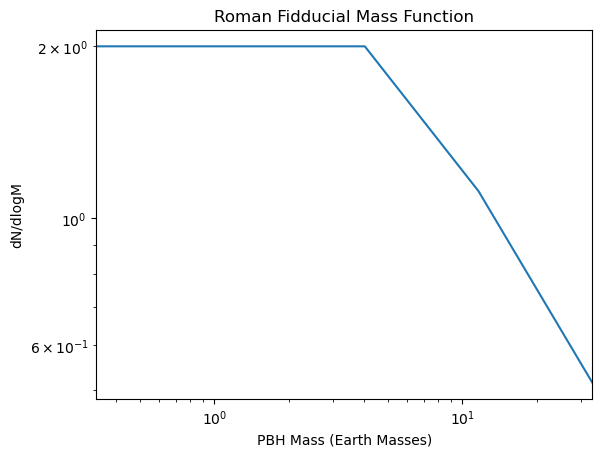

In [270]:
ms_1 = np.logspace(-16, np.log10(M_EARTH*5.2))
ms_2 = np.logspace(np.log10(M_EARTH*5.2), -1)

roman_dndlogm = np.array([2]*len(ms_1))
roman_dndlogm = np.append(roman_dndlogm, dN_dlogM(0.24, ms_2, 95*M_EARTH, 0.73))
# roman_dndlogm = np.append(roman_dndlogm, dN_dlogM(1/16.33180998152758, ms_2, 95*M_EARTH, 1.2))

roman_dndlogm_interp = interp1d(np.log10(np.append(ms_1, ms_2)), roman_dndlogm)

roman_dns = roman_dndlogm_interp(np.log10(m_pbhs))

plt.loglog(m_pbhs/M_EARTH, roman_dns)
plt.xlabel('PBH Mass (Earth Masses)')
plt.ylabel('dN/dlogM')
plt.title('Roman Fidducial Mass Function')

plt.xlim(1e-6/M_EARTH, 1e-4/M_EARTH)
plt.show()

In [271]:
def mass_in_ffps_dex(M, p):
    s.add_ffp(p)
    #number of ffps per star per Z
    # N_ffp_per_Z = nquad(s.ffp.mass_func,[[np.log10(M)-0.5,np.log10(M)+0.5]], opts={'points': [np.log10(1e-15), np.log10(1e-15*1e3)]})[0]
    N_ffp_per_Z = 1

    mass_ffp_per_Z = N_ffp_per_Z * M
    return mass_ffp_per_Z


In [272]:
def mass_in_ffps_dex_roman(M):
    N_ffp_roman = nquad(roman_dndlogm_interp, [[np.log10(M)-0.5,np.log10(M)+0.5]])[0]
    return N_ffp_roman*M

print(mass_in_ffps_dex_roman(3e-6))
ms_roman = np.logspace(-15, -3, 100)
m_ffps_roman = np.array([mass_in_ffps_dex_roman(m) for m in ms_roman])

6e-06


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


In [273]:
m_ffps_066 = np.array([mass_in_ffps_dex(m, 0.66)*z_066 for m in ms_earth])
m_ffps_133 = np.array([mass_in_ffps_dex(m, 1.33)*z_133 for m in ms_earth])

In [274]:
roman_exclusion_ms = np.logspace(-4, 4, 100)
roman_exlusions = roman_exclusion_interp(roman_exclusion_ms)

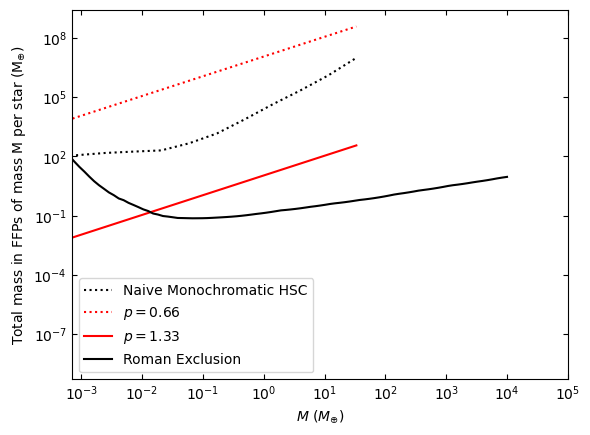

In [275]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls=':', label='Naive Monochromatic HSC')
plt.loglog(ms_earth, m_ffps_066/M_EARTH, 'r', ls=':', label=r'$p=0.66$')
plt.loglog(ms_earth, m_ffps_133/M_EARTH, 'r', ls='-', label=r'$p=1.33$')
# plt.loglog(ms_roman/M_EARTH, m_ffps_roman/M_EARTH, 'Blue', ls='-.', label='Roman')
plt.loglog(roman_exclusion_ms, roman_exlusions, 'k', ls='-', label='Roman Exclusion')

plt.xlim(7e-4, 1e5)
# plt.ylim(7e-3, 1e6)

plt.xlabel(r'$M$ ($M_{\oplus}$)')
plt.ylabel('Total mass in FFPs of mass M per star (M$_{\oplus}$)')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend()

plt.show()

In [311]:
def monochromatic_rate_ffp(m):

    ti = 0.07
    # tf = 3
    tf = 3*10

    #note p doesn't matter for monochromatic
    s.add_ffp(1)
    f = s.ffp
    ts = np.logspace(-2, 2, num=40)
    # diff_rates_monochromatic_m31 = []
    diff_rates_monochromatic_mw = []
    for t in ts:
        # diff_rates_monochromatic_m31.append(f.differential_rate_m31_monochromatic(t, finite=True, m=m))
        diff_rates_monochromatic_mw.append(f.differential_rate_mw_monochromatic(t, finite=True, m=m))
    
    # diff_interp_m31 = interp1d(ts, diff_rates_monochromatic_m31)
    diff_interp_mw = interp1d(ts, diff_rates_monochromatic_mw)

    # quad_m31 = quad(diff_interp_m31, ti, tf)[0]
    quad_mw = quad(diff_interp_mw, ti, tf)[0]

    # return quad_m31 + quad_mw
    return quad_mw


def expected_nevents_ffp_monochromatic(m):
    dnds = monochromatic_rate_ffp(m)
    n_exp = s.n_sources*efficiency*obsTime*dnds
    return n_exp

In [254]:
our_N_ffp_perstar = 4.74/np.array([expected_nevents_ffp_monochromatic(m) for m in m_pbhs])

In [314]:
#Bulge LOS and 10x longer obs time
our_N_ffp_perstar10 = 4.74/np.array([expected_nevents_ffp_monochromatic(m) for m in m_pbhs])

Text(0, 0.5, 'M_ffp_perstar (M_Earth)')

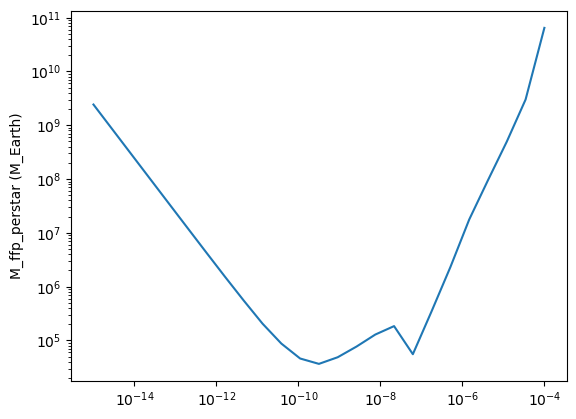

In [ ]:
plt.loglog(m_pbhs, our_N_ffp_perstar*m_pbhs/M_EARTH)
plt.loglog(m_pbhs, our_N_ffp_perstar10*m_pbhs/M_EARTH, ls='--', label='10x longer obs time')

# plt.ylabel('N_ffp_perstar')
plt.ylabel('M_ffp_perstar (M_Earth)')


In [288]:
our_Mffp_perstar_earth = our_N_ffp_perstar *m_pbhs/M_EARTH # Mass of FFPs per star in earth masses

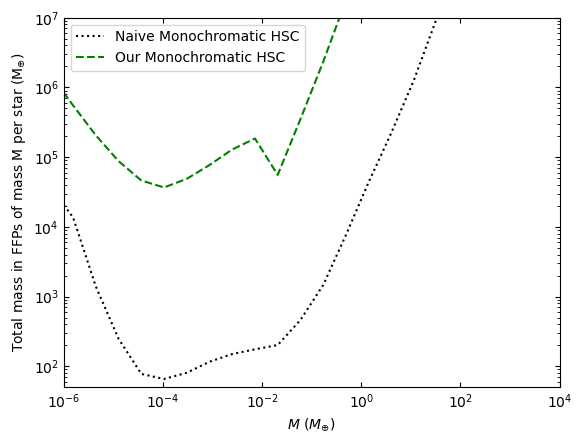

In [299]:
plt.loglog(ms_earth, f_HM_earth, 'k', ls=':', label='Naive Monochromatic HSC')
plt.loglog(ms_earth, our_Mffp_perstar_earth, 'green', ls='--', label='Our Monochromatic HSC')
# plt.loglog(roman_exclusion_ms, roman_exlusions, 'k', ls='-', label='Roman Exclusion')

# plt.xlim(7e-4, 1e4)
# plt.ylim(7e-3, 1e6)
plt.xlim(1e-6, 1e4)
plt.ylim(5e1, 1e7)


plt.xlabel(r'$M$ ($M_{\oplus}$)')
plt.ylabel('Total mass in FFPs of mass M per star (M$_{\oplus}$)')

plt.tick_params(axis='x', which='both', top=True, direction='in')
plt.tick_params(axis='y', which='both', right=True, direction='in')

# Set the tick spacing on the x-axis to be twice as dense
ax = plt.gca()
ax.xaxis.set_major_locator(plt.LogLocator(base=10.0, numticks=10))

plt.legend()

plt.show()